In [5]:
import tensorflow as tf

def generate_fgsm(image, model, epsilon):
    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        target_class = tf.argmax(prediction[0])
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_class, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)  # Ensure pixel values are in [0, 1] range
    
    return perturbed_image.numpy()[0]

# Test on image from numbers dataset

aaa
1/1 [==============================] - 0s 110ms/step


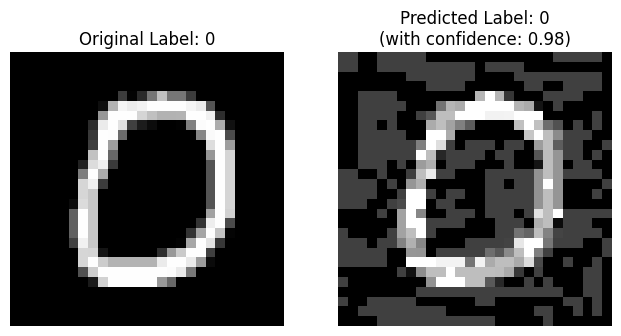

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select a random image from the test dataset
random_index = 10 #np.random.randint(0, len(test_images))
input_image = test_images[random_index]
original_label = test_labels[random_index]

# Define an epsilon value for the FGSM attack
epsilon = 0.25

# Use the generate_fgsm function to generate a perturbed image
perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

#perturbed_image = generate_targeted_fgsm(input_image, fcn_model, epsilon, 5)

# Calculate the difference between the original and perturbed images
difference_image = input_image - perturbed_image

# Perform inference on the perturbed image
perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
predictions = fcn_model.predict(perturbed_image_reshaped)

# Get the predicted class label
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the original image, perturbed image, and the difference
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title(f'Original Label: {original_label}')
plt.axis('off')

plt.subplot(132)
plt.imshow(perturbed_image_reshaped[0], cmap='gray')
plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 23ms/step


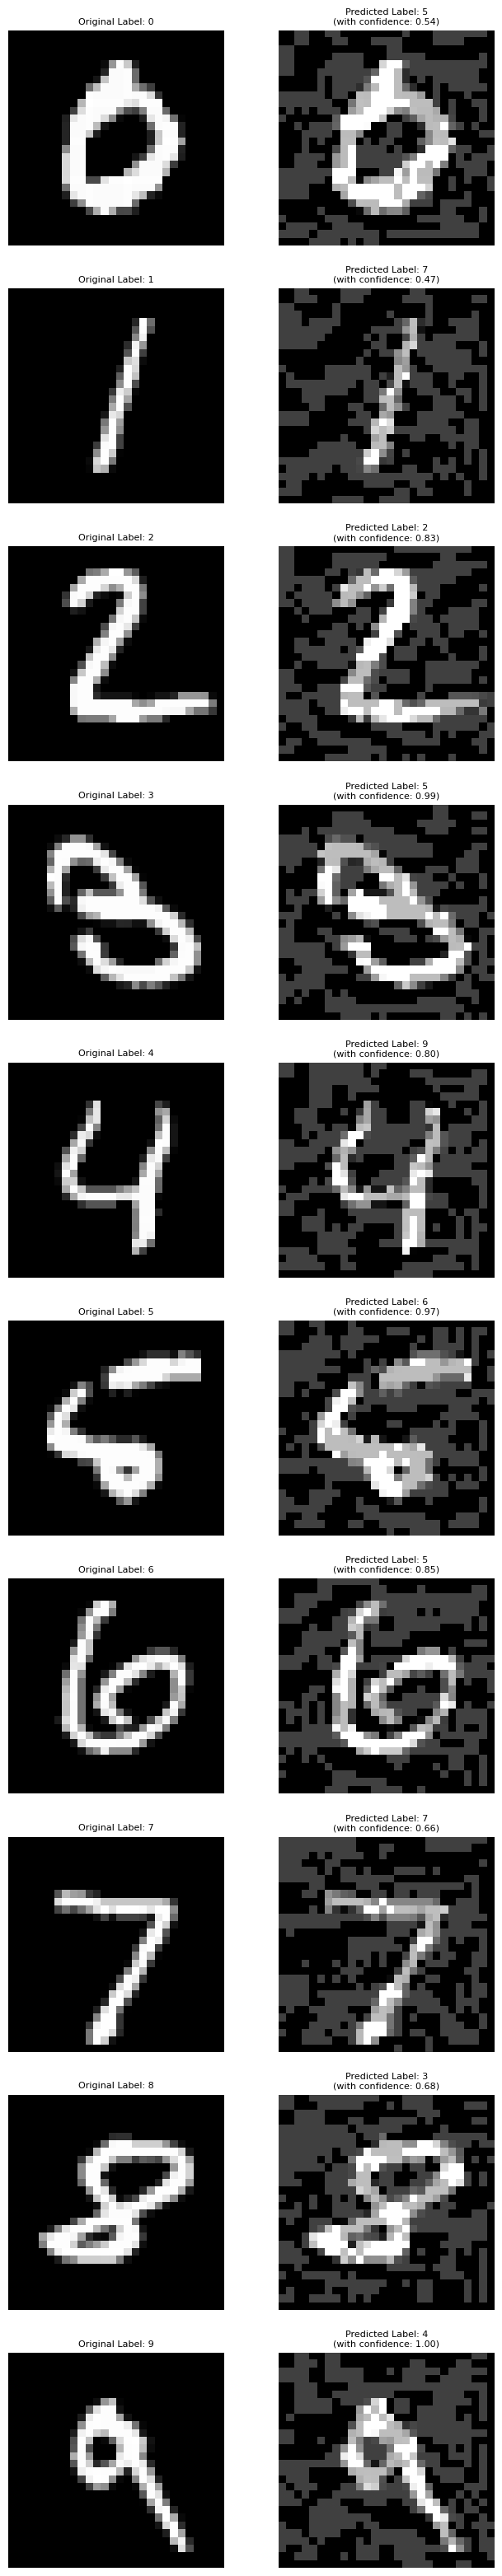

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select one sample from each class in the test dataset
indices = []
for i in range(10):  # Assuming there are 10 classes
    indices.append(np.where(test_labels == i)[0][0])

# Define an epsilon value for the FGSM attack
epsilon = 0.25

plt.figure(figsize=(12, 40))

for i, index in enumerate(indices):
    input_image = test_images[index]
    original_label = test_labels[index]

    # Use the generate_fgsm function to generate a perturbed image
    perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

    # Calculate the difference between the original and perturbed images
    difference_image = input_image - perturbed_image

    # Perform inference on the perturbed image
    perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
    predictions = fcn_model.predict(perturbed_image_reshaped)

    # Get the predicted class label
    predicted_label = np.argmax(predictions)
    confidence = np.max(predictions)

    # Display the original image, perturbed image, and the difference
    plt.subplot(10, 3, i*3+1)
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Original Label: {original_label}',fontsize=8)
    plt.axis('off')

    plt.subplot(10, 3, i*3+2)
    plt.imshow(perturbed_image_reshaped[0], cmap='gray')
    plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})',fontsize=8)
    plt.axis('off')

plt.show()


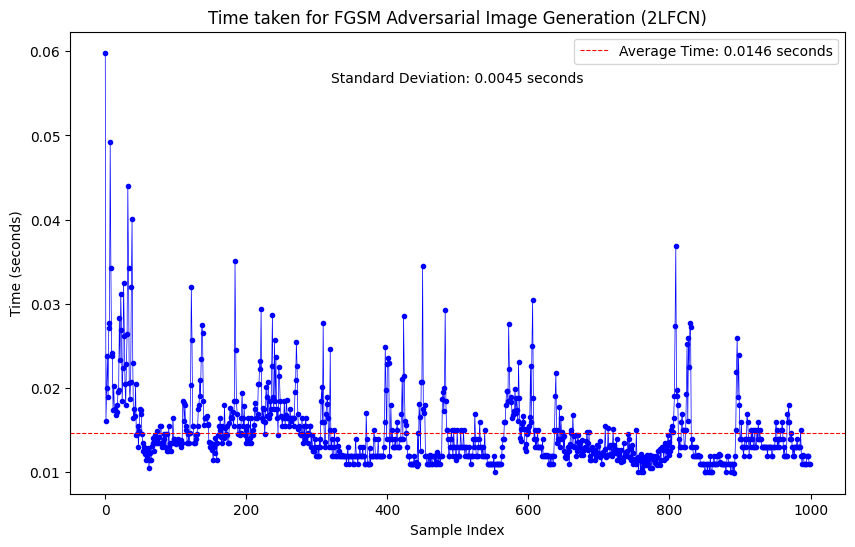

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Number of samples
num_samples = 1000

# Define epsilon value for the FGSM attack
epsilon = 0.25

# Lists to store time taken for each sample
generation_times = []

# Generate adversarial images and record time
for _ in range(num_samples):
    # Select a random image from the test dataset
    random_index = np.random.randint(0, len(test_images))
    input_image = test_images[random_index]

    # Record start time
    start_time = time.time()

    # Use the generate_fgsm function to generate a perturbed image
    perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

    # Record end time
    end_time = time.time()

    # Record the time taken for this sample
    generation_time = end_time - start_time
    generation_times.append(generation_time)

# Calculate the average time taken and standard deviation
average_time = np.mean(generation_times)
std_deviation = np.std(generation_times)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(generation_times, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3)
plt.axhline(y=average_time, color='r', linestyle='--', linewidth=0.8, label=f'Average Time: {average_time:.4f} seconds')
plt.title('Time taken for FGSM Adversarial Image Generation (2LFCN)')
plt.xlabel('Sample Index')
plt.ylabel('Time (seconds)')
plt.legend()

# Display standard deviation as a text annotation
plt.text(0.5, 0.9, f'Standard Deviation: {std_deviation:.4f} seconds',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

plt.show()


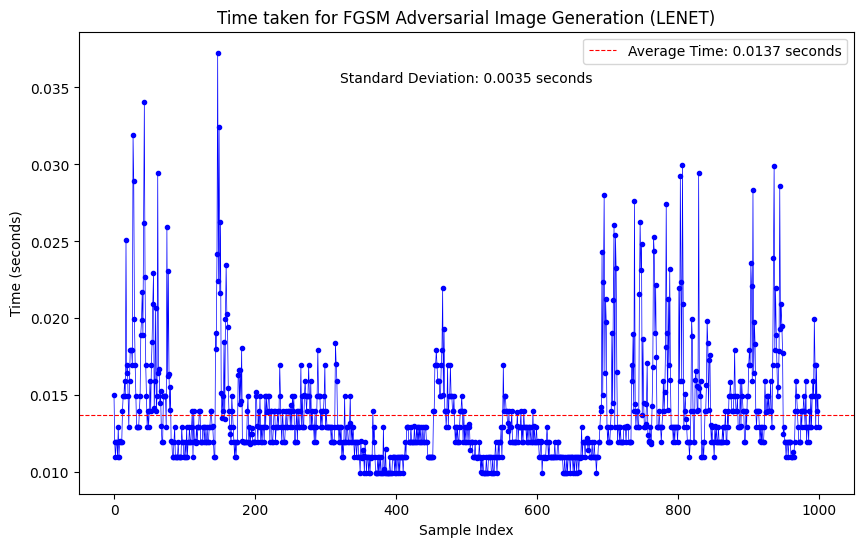

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Number of samples
num_samples = 1000

# Define epsilon value for the FGSM attack
epsilon = 0.25

# Lists to store time taken for each sample
generation_times = []

# Generate adversarial images and record time
for _ in range(num_samples):
    # Select a random image from the test dataset
    random_index = np.random.randint(0, len(test_images))
    input_image = test_images[random_index]

    # Record start time
    start_time = time.time()

    # Use the generate_fgsm function to generate a perturbed image
    perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

    # Record end time
    end_time = time.time()

    # Record the time taken for this sample
    generation_time = end_time - start_time
    generation_times.append(generation_time)

# Calculate the average time taken and standard deviation
average_time = np.mean(generation_times)
std_deviation = np.std(generation_times)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(generation_times, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3)
plt.axhline(y=average_time, color='r', linestyle='--', linewidth=0.8, label=f'Average Time: {average_time:.4f} seconds')
plt.title('Time taken for FGSM Adversarial Image Generation (LENET)')
plt.xlabel('Sample Index')
plt.ylabel('Time (seconds)')
plt.legend()

# Display standard deviation as a text annotation
plt.text(0.5, 0.9, f'Standard Deviation: {std_deviation:.4f} seconds',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

plt.show()


1/1 [==============================] - 0s 27ms/step


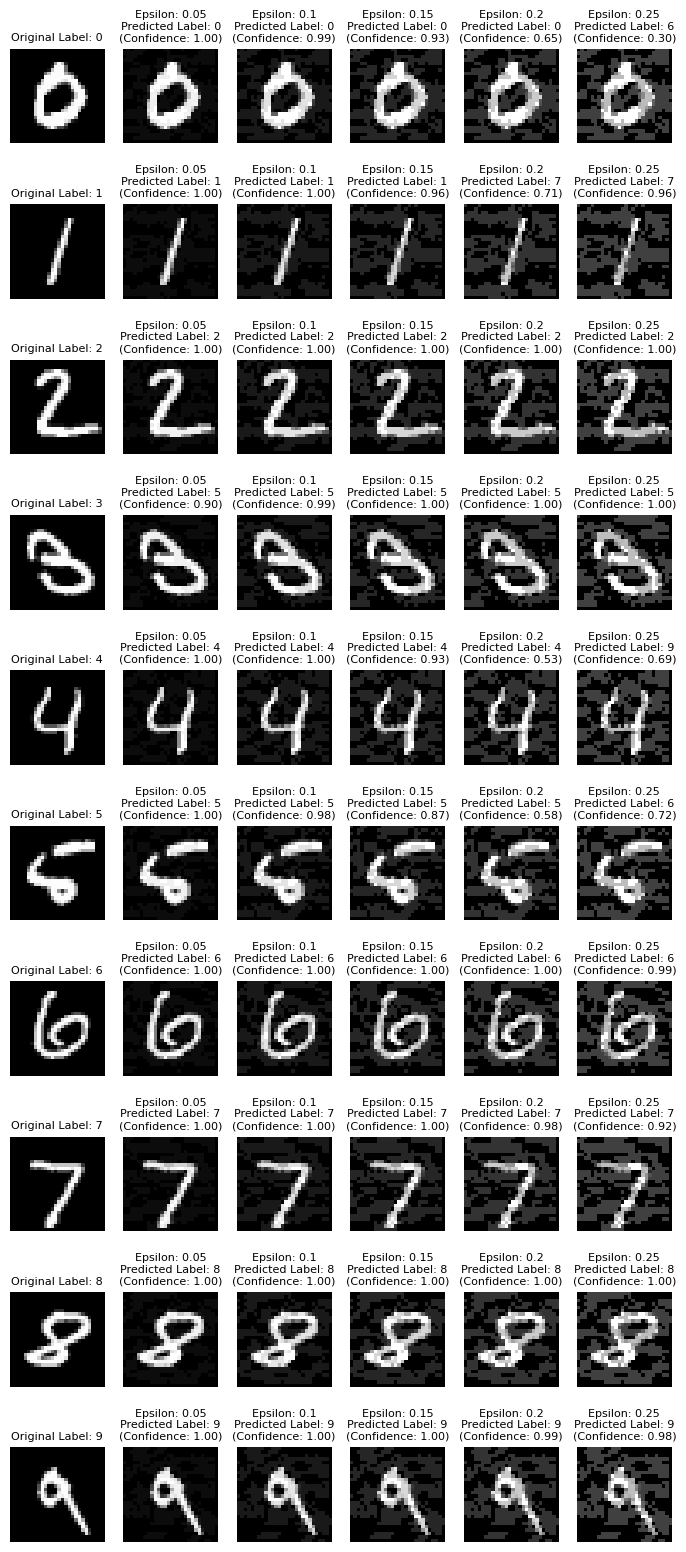

In [217]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(45)
tf.random.set_seed(45)

# Load the FCN model you created earlier
leNet_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select one sample from each class in the test dataset
indices = []
for i in range(10):  # Assuming there are 10 classes
    indices.append(np.where(test_labels == i)[0][0])

# Define a list of epsilon values for the FGSM attack
epsilons = [0, 0.05, .1, .15, .2, .25]

plt.figure(figsize=(10, 20))

for i, index in enumerate(indices):
    input_image = test_images[index]
    original_label = test_labels[index]

    for j, epsilon in enumerate(epsilons):
        # Use the generate_fgsm function to generate a perturbed image
        perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

        # Perform inference on the perturbed image
        perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
        predictions = leNet_model.predict(perturbed_image_reshaped)

        # Get the predicted class label
        predicted_label = np.argmax(predictions)
        confidence = np.max(predictions)

        # Display the original image and perturbed images
        plt.subplot(10, len(epsilons)+1, i*(len(epsilons)+1)+j+1)
        if j == 0:
            plt.imshow(input_image, cmap='gray')
            plt.title(f'Original Label: {original_label}',fontsize=8)
        else:
            plt.imshow(perturbed_image_reshaped[0], cmap='gray')
            plt.title(f'Epsilon: {epsilon}\nPredicted Label: {predicted_label}\n(Confidence: {confidence:.2f})',fontsize=8)
        plt.axis('off')

# Adjust the spacing between rows
plt.subplots_adjust(hspace=0.1)

plt.show()


In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0  # Preprocess the training data
test_images = test_images / 255.0  # Preprocess the test data

# Define epsilon for the FGSM attack
epsilon = 0.25

# Specify the number of perturbed training and testing images
num_perturbed_train_images = 20000
num_perturbed_test_images = 5000

# Create a new dataset with perturbed training images
perturbed_train_images = []

print("Generating perturbed training images:")
for i, image in enumerate(train_images[:num_perturbed_train_images]):
    perturbed_image = generate_fgsm(image, fcn_model, epsilon)
    perturbed_train_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 1000 == 0 or (i + 1) == num_perturbed_train_images:
        print(f"Processed {i + 1}/{num_perturbed_train_images} images")

perturbed_train_images = np.array(perturbed_train_images)

# Optionally, you can save the perturbed training images and labels to a new dataset
np.savez_compressed('perturbed_mnist_2LFCN_FGSM_train.npz', images=perturbed_train_images, labels=train_labels[:num_perturbed_train_images])

# Create a new dataset with perturbed test images
perturbed_test_images = []

print("\nGenerating perturbed test images:")
for i, image in enumerate(test_images[:num_perturbed_test_images]):
    perturbed_image = generate_fgsm(image, fcn_model, epsilon)
    perturbed_test_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 1000 == 0 or (i + 1) == num_perturbed_test_images:
        print(f"Processed {i + 1}/{num_perturbed_test_images} images")

perturbed_test_images = np.array(perturbed_test_images)

# Optionally, you can save the perturbed test images and labels to a new dataset
np.savez_compressed('perturbed_mnist_2LFCN_FGSM_test.npz', images=perturbed_test_images, labels=test_labels[:num_perturbed_test_images])

Generating perturbed training images:
Processed 1000/20000 images
Processed 2000/20000 images
Processed 3000/20000 images
Processed 4000/20000 images
Processed 5000/20000 images
Processed 6000/20000 images
Processed 7000/20000 images
Processed 8000/20000 images
Processed 9000/20000 images
Processed 10000/20000 images
Processed 11000/20000 images
Processed 12000/20000 images
Processed 13000/20000 images
Processed 14000/20000 images
Processed 15000/20000 images
Processed 16000/20000 images
Processed 17000/20000 images
Processed 18000/20000 images
Processed 19000/20000 images
Processed 20000/20000 images

Generating perturbed test images:
Processed 1000/5000 images
Processed 2000/5000 images
Processed 3000/5000 images
Processed 4000/5000 images
Processed 5000/5000 images


In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the LENET model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0  # Preprocess the training data
test_images = test_images / 255.0  # Preprocess the test data

# Define epsilon for the FGSM attack
epsilon = 0.25

# Specify the number of perturbed training and testing images
num_perturbed_train_images = 20000
num_perturbed_test_images = 5000

# Create a new dataset with perturbed training images
perturbed_train_images = []

print("Generating perturbed training images:")
for i, image in enumerate(train_images[:num_perturbed_train_images]):
    perturbed_image = generate_fgsm(image, fcn_model, epsilon)
    perturbed_train_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 1000 == 0 or (i + 1) == num_perturbed_train_images:
        print(f"Processed {i + 1}/{num_perturbed_train_images} images")

perturbed_train_images = np.array(perturbed_train_images)

# Optionally, you can save the perturbed training images and labels to a new dataset
np.savez_compressed('perturbed_mnist_LENET_FGSM_train.npz', images=perturbed_train_images, labels=train_labels[:num_perturbed_train_images])

# Create a new dataset with perturbed test images
perturbed_test_images = []

print("\nGenerating perturbed test images:")
for i, image in enumerate(test_images[:num_perturbed_test_images]):
    perturbed_image = generate_fgsm(image, fcn_model, epsilon)
    perturbed_test_images.append(perturbed_image)
    
    # Print progress
    if (i + 1) % 1000 == 0 or (i + 1) == num_perturbed_test_images:
        print(f"Processed {i + 1}/{num_perturbed_test_images} images")

perturbed_test_images = np.array(perturbed_test_images)

# Optionally, you can save the perturbed test images and labels to a new dataset
np.savez_compressed('perturbed_mnist_LENET_FGSM_test.npz', images=perturbed_test_images, labels=test_labels[:num_perturbed_test_images])

Generating perturbed training images:
Processed 1000/20000 images
Processed 2000/20000 images
Processed 3000/20000 images
Processed 4000/20000 images
Processed 5000/20000 images
Processed 6000/20000 images
Processed 7000/20000 images
Processed 8000/20000 images
Processed 9000/20000 images
Processed 10000/20000 images
Processed 11000/20000 images
Processed 12000/20000 images
Processed 13000/20000 images
Processed 14000/20000 images
Processed 15000/20000 images
Processed 16000/20000 images
Processed 17000/20000 images
Processed 18000/20000 images
Processed 19000/20000 images
Processed 20000/20000 images

Generating perturbed test images:
Processed 1000/5000 images
Processed 2000/5000 images
Processed 3000/5000 images
Processed 4000/5000 images
Processed 5000/5000 images


157/157 [==============================] - 1s 6ms/step
Accuracy on perturbed dataset: 25.56%


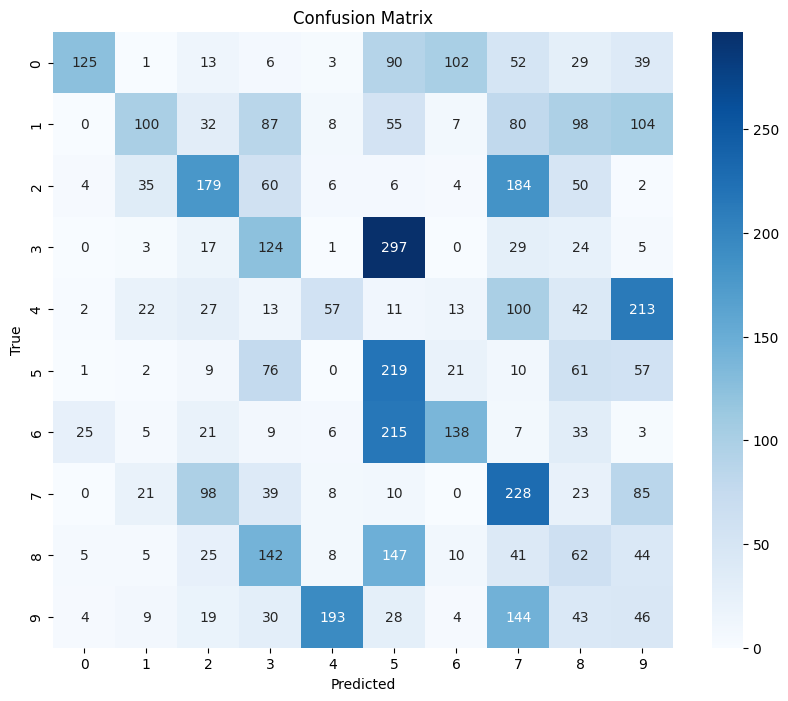

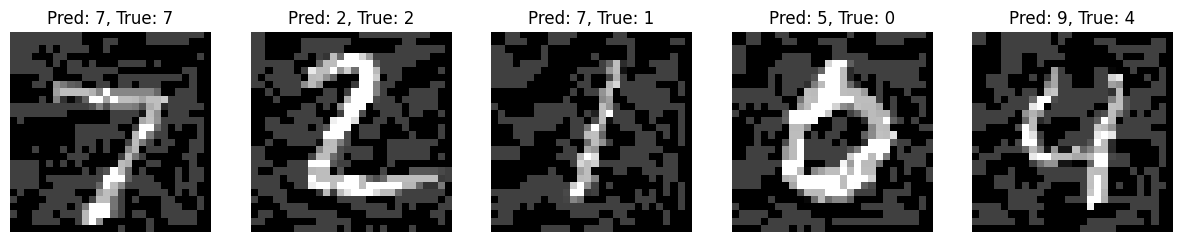

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 8ms/step
Accuracy on perturbed dataset: 74.36%


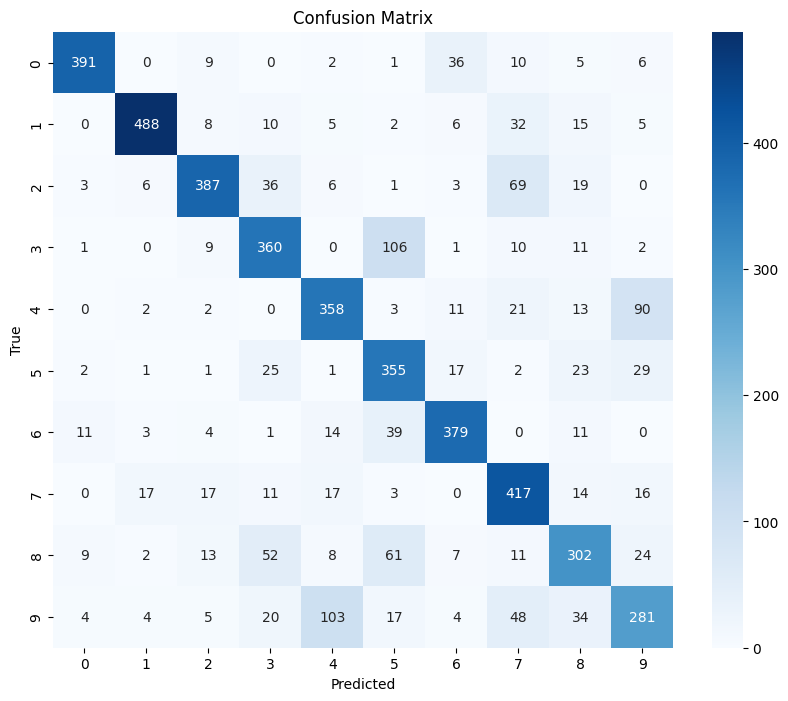

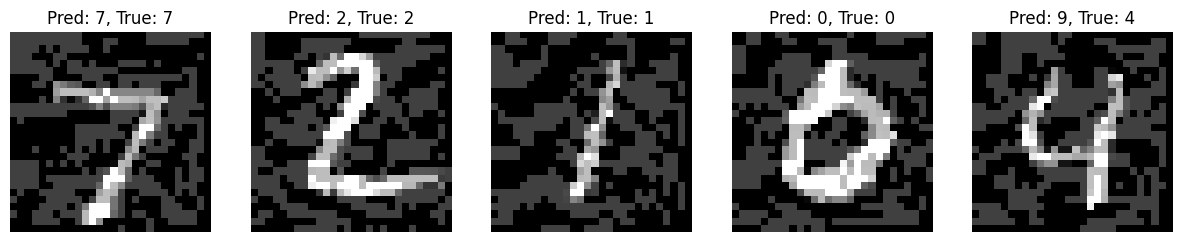

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the LENET model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 4ms/step
Accuracy on perturbed dataset: 64.26%


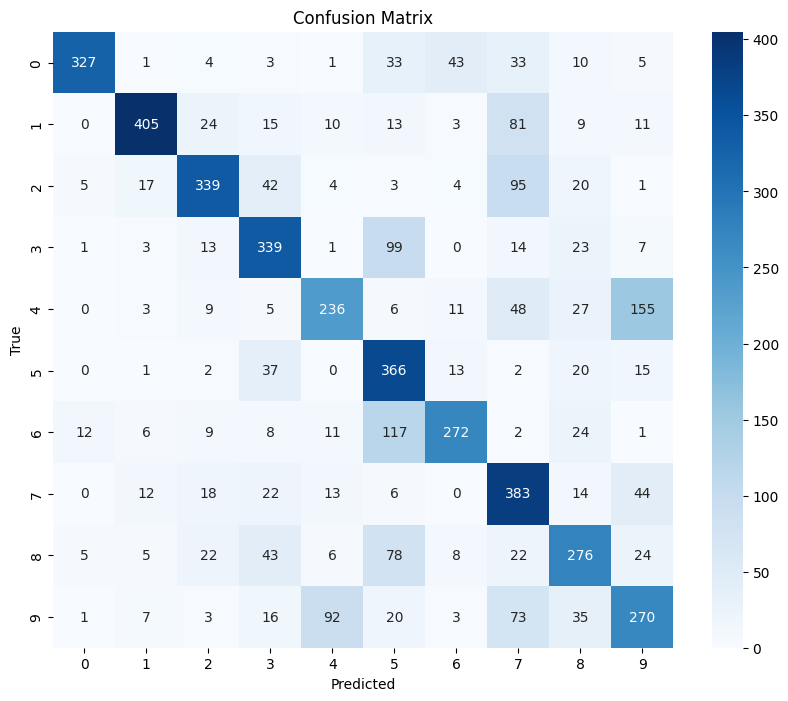

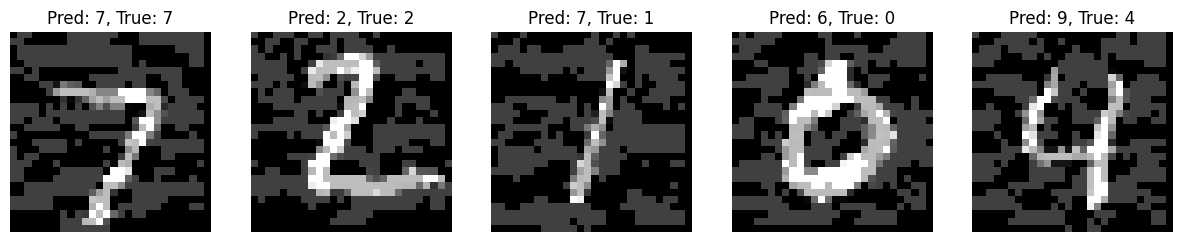

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 5ms/step
Accuracy on perturbed dataset: 24.32%


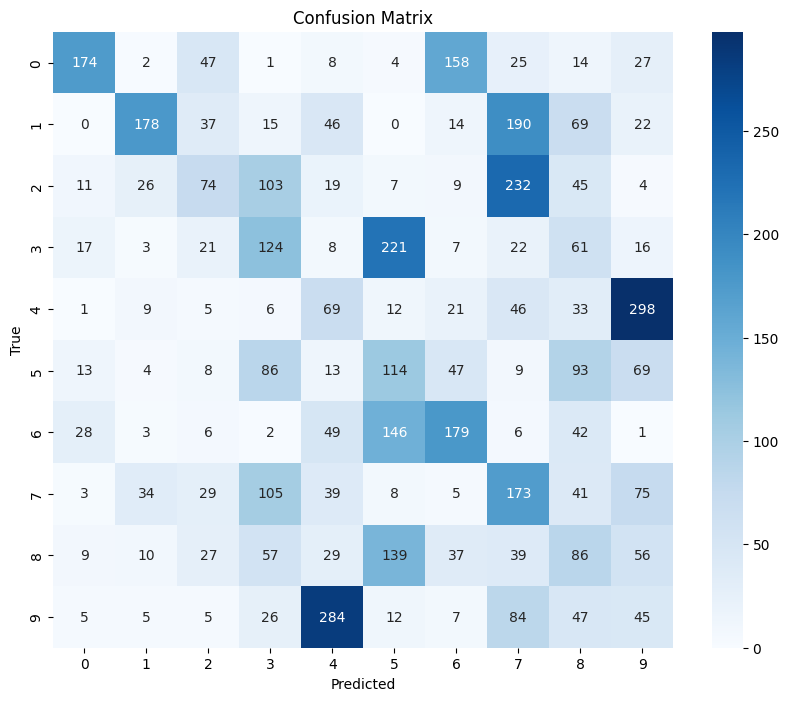

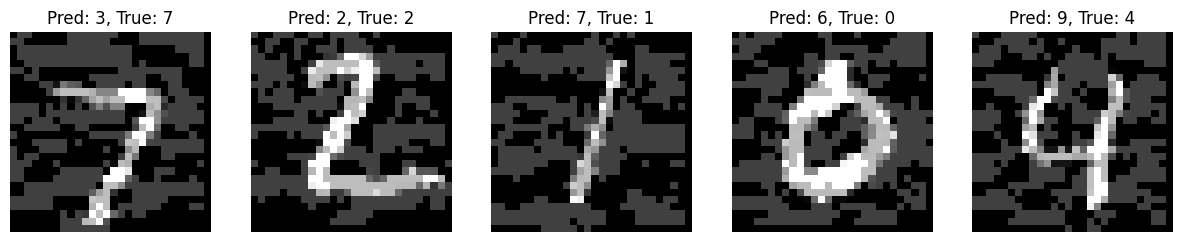

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 7ms/step
Accuracy on perturbed dataset: 68.16%


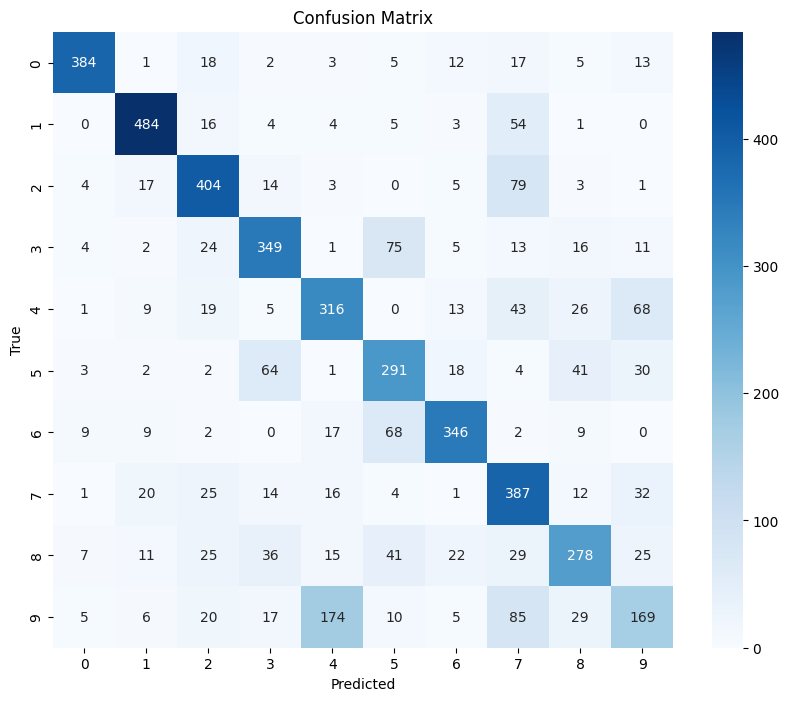

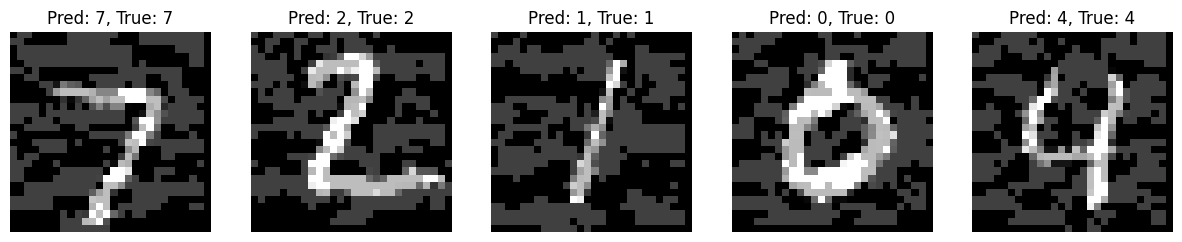

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_LENET_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_LENET_V2.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

157/157 [==============================] - 1s 3ms/step
Accuracy on perturbed dataset: 55.28%


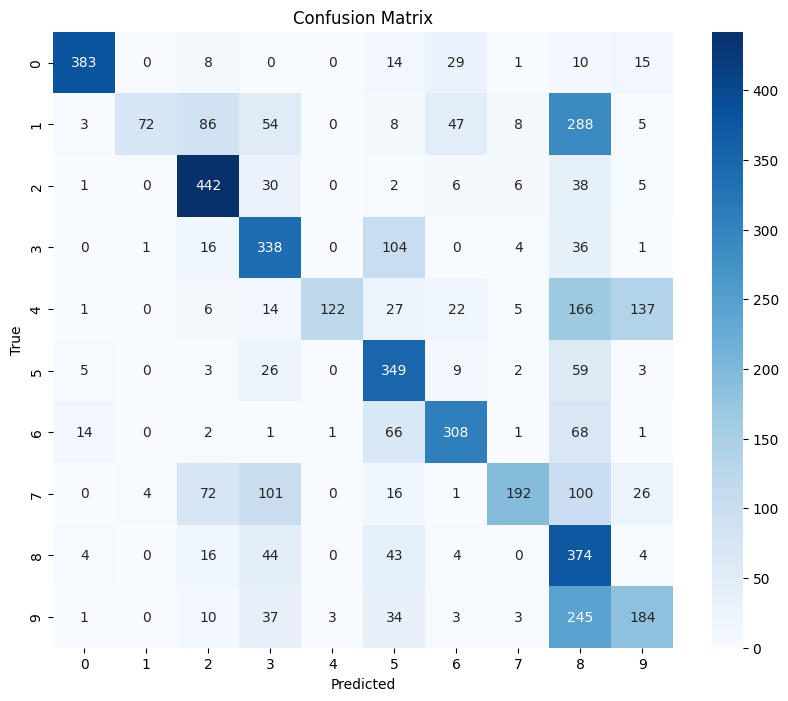

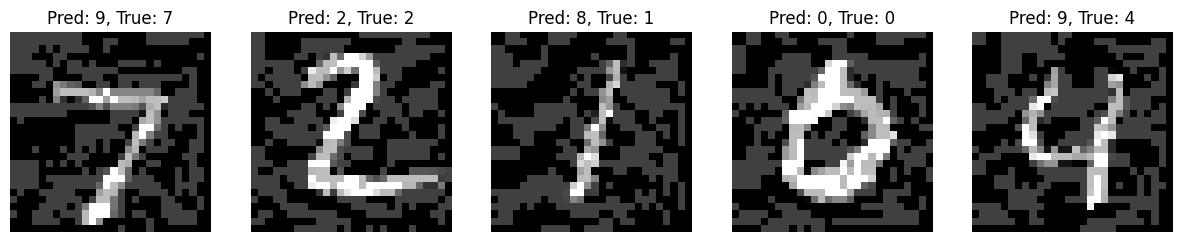

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the perturbed dataset
perturbed_data = np.load('perturbed_mnist_2LFCN_FGSM_test.npz')
perturbed_images = perturbed_data['images']
perturbed_labels = perturbed_data['labels']

# Load the FCN model
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN_V2.karas")

# Perform inference on the perturbed images
predictions = fcn_model.predict(perturbed_images)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the accuracy
accuracy = np.mean(np.equal(predicted_labels, perturbed_labels))
print(f'Accuracy on perturbed dataset: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(perturbed_labels, predicted_labels)
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes (adjust if needed)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display some examples
num_examples = 5
plt.figure(figsize=(15, 4))
for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(perturbed_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_labels[i]}, True: {perturbed_labels[i]}')
    plt.axis('off')

plt.show()

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def generate_fgsm_imgn(image, model, epsilon):
    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image) 
        target_class = tf.argmax(prediction[0])
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_class, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    perturbed_image = image + (epsilon * signed_grad)
    perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)  # Ensure pixel values are in [0, 255] range
    
    return perturbed_image.numpy()[0]

1/1 [==============================] - 0s 63ms/step


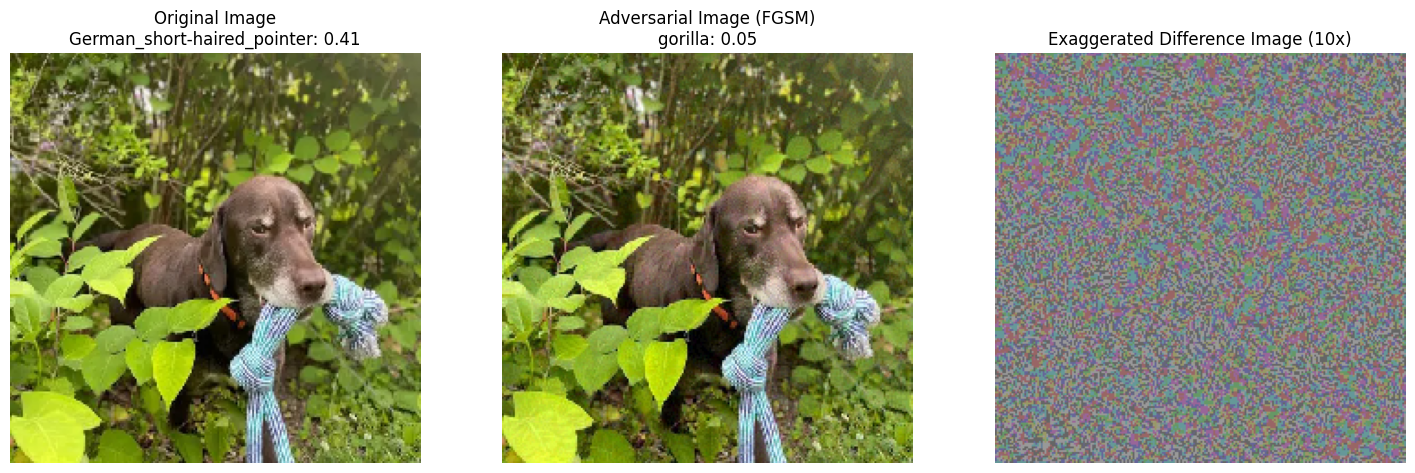

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained MobileNetV2 model trained on ImageNet
model = MobileNetV2(weights='imagenet')

# Load an example ImageNet image
image_path = "../DataFiles/IMG_1118_400x354.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = preprocess_input(tf.keras.preprocessing.image.img_to_array(image))

# Generate FGSM adversarial image
epsilon = 0.04
adversarial_image = generate_fgsm_imgn(image, model, epsilon)

# Function to exaggerate the difference in the image
def exaggerate_difference(difference_image, exaggeration_factor):
    return difference_image * exaggeration_factor

# Function to get predictions and confidence
def get_predictions_and_confidence(image, model):
    image_batch = tf.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    decoded_predictions = decode_predictions(predictions)
    top_prediction = decoded_predictions[0][0]

    return f"{top_prediction[1]}: {top_prediction[2]:.2f}"

# Get predictions and confidence for the original and adversarial images
original_prediction = get_predictions_and_confidence(image, model)
adversarial_prediction = get_predictions_and_confidence(adversarial_image, model)

image = image * 0.5 + 0.5
adversarial_image = adversarial_image * 0.5 + 0.5

# Generate and exaggerate the difference image
difference_image = adversarial_image - image
exaggeration_factor = 10  # Adjust this factor to control the exaggeration
exaggerated_difference_image = exaggerate_difference(difference_image, exaggeration_factor)
exaggerated_difference_image = (exaggerated_difference_image + 1) / 2  # Normalize to [0, 1]

# Display the original, adversarial, and exaggerated difference images with predictions and confidence
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f'Original Image\n{original_prediction}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adversarial_image)
plt.title(f'Adversarial Image (FGSM)\n{adversarial_prediction}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(exaggerated_difference_image)
plt.title('Exaggerated Difference Image (10x)')
plt.axis('off')

plt.show()